In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from vae import VAE
from loss_function import loss_function

## Hyperparmeters

In [3]:
batch_size = 256
input_dim = 31

## Load Data

In [4]:
# file located at '/data' in parent directory
path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'creditcard.csv')) 
df = pd.read_csv(path)
df['Time_diff_from_previous'] = df['Time'].diff()
df['Time_diff_from_previous'].iloc[0] = 0
df['Time_diff_from_last'] = df['Time'].diff().iloc[1:].reset_index(drop=True)
df['Time_diff_from_last'].iloc[-1] = 0

for column in df.columns[0:30] : 
    df[column] = df[column] / (df[column].max() - df[column].min())
df['Time_diff_from_previous'] = df['Time_diff_from_previous'] / (df['Time_diff_from_previous'].max() - df['Time_diff_from_previous'].min())
df['Time_diff_from_last'] = df['Time_diff_from_last'] / (df['Time_diff_from_last'].max() - df['Time_diff_from_last'].min())

df = df.drop(['Time'], axis=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
display(df.head())

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V23,V24,V25,V26,V27,V28,Amount,Class,Time_diff_from_previous,Time_diff_from_last
0,-0.023101,-0.000768,0.043951,0.061092,-0.002278,0.004649,0.001460,0.001059,0.012532,0.001878,...,-0.001641,0.009019,0.007215,-0.030892,0.002465,-0.000427,0.005824,0,0.00000,0.00000
1,0.020248,0.002808,0.002885,0.019866,0.000404,-0.000828,-0.000480,0.000913,-0.008799,-0.003455,...,0.001504,-0.045794,0.009384,0.020565,-0.000166,0.000299,0.000105,0,0.00000,0.03125
2,-0.023077,-0.014141,0.030727,0.016835,-0.003388,0.018102,0.004822,0.002657,-0.052177,0.004296,...,0.013506,-0.092880,-0.018391,-0.022721,-0.001022,-0.001213,0.014739,0,0.03125,0.00000
3,-0.016416,-0.001954,0.031070,-0.038269,-0.000069,0.012539,0.001448,0.004049,-0.047781,-0.001137,...,-0.002826,-0.158408,0.036339,-0.036252,0.001158,0.001247,0.004807,0,0.00000,0.03125
4,-0.019677,0.009261,0.026837,0.017866,-0.002741,0.000964,0.003612,-0.002902,0.028170,0.015581,...,-0.002041,0.019036,-0.011564,0.082048,0.004050,0.004366,0.002724,0,0.03125,0.00000


# Split Data

In [6]:
split_ratio = [0.6, 0.2, 0.2]

In [7]:
class CCFDataset(Dataset) : 
    def __init__(self, df, transform=transforms.ToTensor()) :
        self.df = df.reset_index(drop=True)
        
    def __len__(self) :
        return self.df.shape[0]
    
    def __getitem__(self, idx) :
        # x, y
        x = torch.from_numpy(self.df.drop(['Class'], axis=1).iloc[idx].values).type('torch.FloatTensor')
        #y = torch.from_numpy(self.df['Class'].iloc[idx]).type('torch.FloatTensor')
        y = torch.tensor([self.df['Class'].iloc[idx]], dtype=torch.float32)
        return x, y 

In [8]:
def split_data(seed, split_ratio) : 
    train_ratio = split_ratio[0]
    valid_ratio = split_ratio[1]
    test_ratio = split_ratio[2]
    # normal
    normal_data = df[df['Class']==0]
    normal_data = normal_data.reset_index(drop=True)
    # novelty
    novel_data = df[df['Class']==1]
    novel_data = novel_data.reset_index(drop=True)
    
    train_size = int(normal_data.shape[0]*train_ratio) # 60% train
    valid_size = int(normal_data.shape[0]*valid_ratio) # 20% valid
    test_size = int(normal_data.shape[0]*test_ratio) # 20% test
  
    # split train, valid, test
    train_data = normal_data[:train_size]
    valid_data = normal_data[train_size:train_size+valid_size]
    test_data = normal_data[train_size+valid_size:]
    
    test_data = pd.concat([test_data, novel_data])
    
    train_dataset = CCFDataset(train_data)
    valid_dataset = CCFDataset(valid_data)
    test_dataset = CCFDataset(test_data)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    
    return train_loader, valid_loader, test_loader

## input_dim=31 (except 'Time', 'Class'), hnum =1, z=5


666.36328125


/home/wakanda/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch 0 Batch 0 loss : 2010.1145
Train Epoch 0 Batch 50 loss : 1367.1299
Train Epoch 0 Batch 100 loss : 788.3542
Train Epoch 0 Batch 150 loss : 431.2951
Train Epoch 0 Batch 200 loss : 283.1379
Train Epoch 0 Batch 250 loss : 200.7375
Train Epoch 0 Batch 300 loss : 137.4298
Train Epoch 0 Batch 350 loss : 98.2401
Train Epoch 0 Batch 400 loss : 69.8351
Train Epoch 0 Batch 450 loss : 50.4254
Train Epoch 0 Batch 500 loss : 39.0235
Train Epoch 0 Batch 550 loss : 33.2224
Train Epoch 0 Batch 600 loss : 29.5727
Train Epoch 0 Batch 650 loss : 27.5031
Valid Epoch 0 Batch 0 loss : 96.2912
Valid Epoch 0 Batch 50 loss : 94.8732
Valid Epoch 0 Batch 100 loss : 94.8177
Valid Epoch 0 Batch 150 loss : 96.5335
Valid Epoch 0 Batch 200 loss : 97.9995
Test Epoch 0 Batch 0 loss : 95.1167
Test Epoch 0 Batch 50 loss : 96.4028
Test Epoch 0 Batch 100 loss : 96.5434
Test Epoch 0 Batch 150 loss : 100.2075
Test Epoch 0 Batch 200 loss : 96.7765
Train Epoch 1 Batch 0 loss : 26.1105
Train Epoch 1 Batch 50 loss : 2

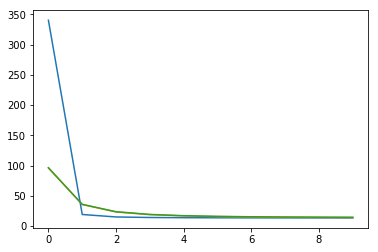

In [9]:
seed = 1
zdims = 5
h_num = 1
epochs = 10
split_ratio = [0.6, 0.2, 0.2]


model = VAE(input_dim, zdims, h_num)
train_loader, valid_loader, test_loader = split_data(seed, split_ratio)

# train, validate the architecture
train_loss_list = []
valid_loss_list = []
test_loss_list = []
lowset_valid_loss = 0
best_model = copy.deepcopy(model)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
print((len(train_loader.dataset) / batch_size))    

for idx_epoch, epoch in enumerate(range(1, epochs+1)) :
    # toggle train mode, intilaize loss for current epoch
    model.train()
    train_loss = 0
    valid_loss = 0
    test_loss = 0
        
    # training set 
    for idx_batch, (data, _) in enumerate(train_loader) :
        # initilaize
        optimizer.zero_grad()
        # prediction
        recon_batch, mu, logvar = model(data)
        # get loss
        loss = loss_function(recon_batch, data, mu, logvar, batch_size, input_dim)
        if idx_batch % 50 == 0 :
            print('Train Epoch %d Batch %d loss : %.4f' % (idx_epoch, idx_batch, loss.item()))
        # backpropagate
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        
    train_loss = train_loss / (len(train_loader.dataset) / batch_size)
    train_loss_list.append(train_loss)
        
    # validation set
    model.eval()
    for idx_batch, (data, _) in enumerate(valid_loader) :
        with torch.no_grad() :
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar, batch_size, input_dim)
            if idx_batch % 50 == 0 :
                print('Valid Epoch %d Batch %d loss : %.4f' % (idx_epoch, idx_batch, loss.item()))
            valid_loss += loss.item()
        
    valid_loss = valid_loss / (len(valid_loader.dataset) / batch_size)
    valid_loss_list.append(valid_loss)
    
    # get best model
    if epoch == 1 :
        lowest_valid_loss = valid_loss
    else : 
        if valid_loss <= lowest_valid_loss :
            lowest_valid_loss = valid_loss
            best_model = copy.deepcopy(model)
    
    # test set
    for idx_batch, (data, _) in enumerate(test_loader) :
        with torch.no_grad() :
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar, batch_size, input_dim)
            if idx_batch % 50 == 0 :
                print('Test Epoch %d Batch %d loss : %.4f' % (idx_epoch, idx_batch, loss.item()))
            test_loss += loss.item()
        
    test_loss = test_loss / (len(test_loader.dataset) / batch_size)
    test_loss_list.append(test_loss)

filepath = 'model1.mdl'
torch.save(best_model.state_dict(), filepath)
    
plt.plot(train_loss_list)
plt.plot(valid_loss_list)
plt.plot(test_loss_list)
plt.show()


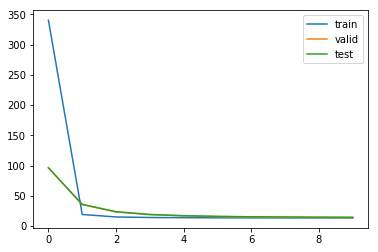

In [10]:
plt.plot(train_loss_list, label='train')
plt.plot(valid_loss_list, label='valid')
plt.plot(test_loss_list, label='test')
plt.legend()
plt.show()

In [11]:


#model = VAE(input_dim, zdims, h_num)
#model.load_state_dict(torch.load(filepath))
#model.eval()
model = best_model

for idx, (data, y) in enumerate(test_loader) :
        if idx == 0 :
            ytrue = y
            with torch.no_grad() :
                yhat = model(data)
        else :
            ytrue = torch.cat([ytrue, y])
            with torch.no_grad() :
                yhat = torch.cat([yhat, model(data)])
                
from sklearn.metrics import roc_auc_score, average_precision_score

auroc = roc_auc_score(ytrue, yhat)
auprc = average_precision_score(ytrue, yhat)
print('AUROC : ', auroc)
print('AUPRC : ', auprc)

TypeError: expected Tensor as element 0 in argument 0, but got tuple

## input_dim=33, hnum =2, z=5